In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set_style("whitegrid")


In [58]:
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
print(df.head())
print(df.info())


  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon          Car                4.1 

In [59]:
missing = df.isnull().sum()
print("Missing Values:\n", missing)

if missing.sum() == 0:
    print("No missing values found.")


Missing Values:
 Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64
No missing values found.


In [60]:
print(df.describe())
    

         Distance  Delivery_Person_Experience  Restaurant_Rating  \
count  200.000000                  200.000000         200.000000   
mean    11.498050                    5.250000           3.738500   
std      6.841755                    2.745027           0.703021   
min      0.520000                    1.000000           2.500000   
25%      6.090000                    3.000000           3.200000   
50%     10.265000                    5.000000           3.800000   
75%     16.497500                    8.000000           4.300000   
max     24.900000                   10.000000           5.000000   

       Customer_Rating  Delivery_Time   Order_Cost  Tip_Amount  
count       200.000000     200.000000   200.000000  200.000000  
mean          3.686500      70.494950  1046.488700   46.616650  
std           0.697063      29.830694   548.568922   29.361706  
min           2.600000      15.230000   122.300000    1.240000  
25%           3.100000      46.997500   553.270000   21.602500

In [61]:
categorical_cols = df.select_dtypes(include=['object', 'string']).columns

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [62]:
df["Tip_Ratio"] = df["Tip_Amount"] / (df["Order_Cost"] + 1)


In [63]:
if "Traffic_Conditions" in df.columns:
    df["Distance_Traffic"] = df["Distance"] * df.filter(like="Traffic").sum(axis=1)


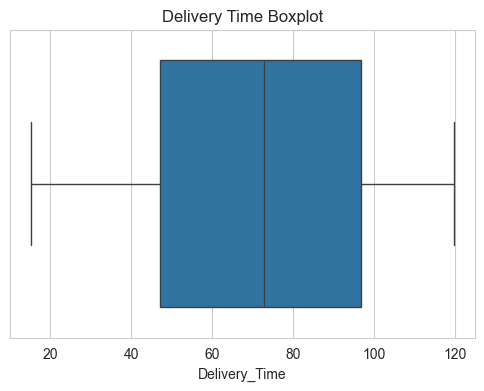

In [64]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Delivery_Time"])
plt.title("Delivery Time Boxplot")
plt.show()


In [65]:
df = df[df["Delivery_Time"] <= 120]


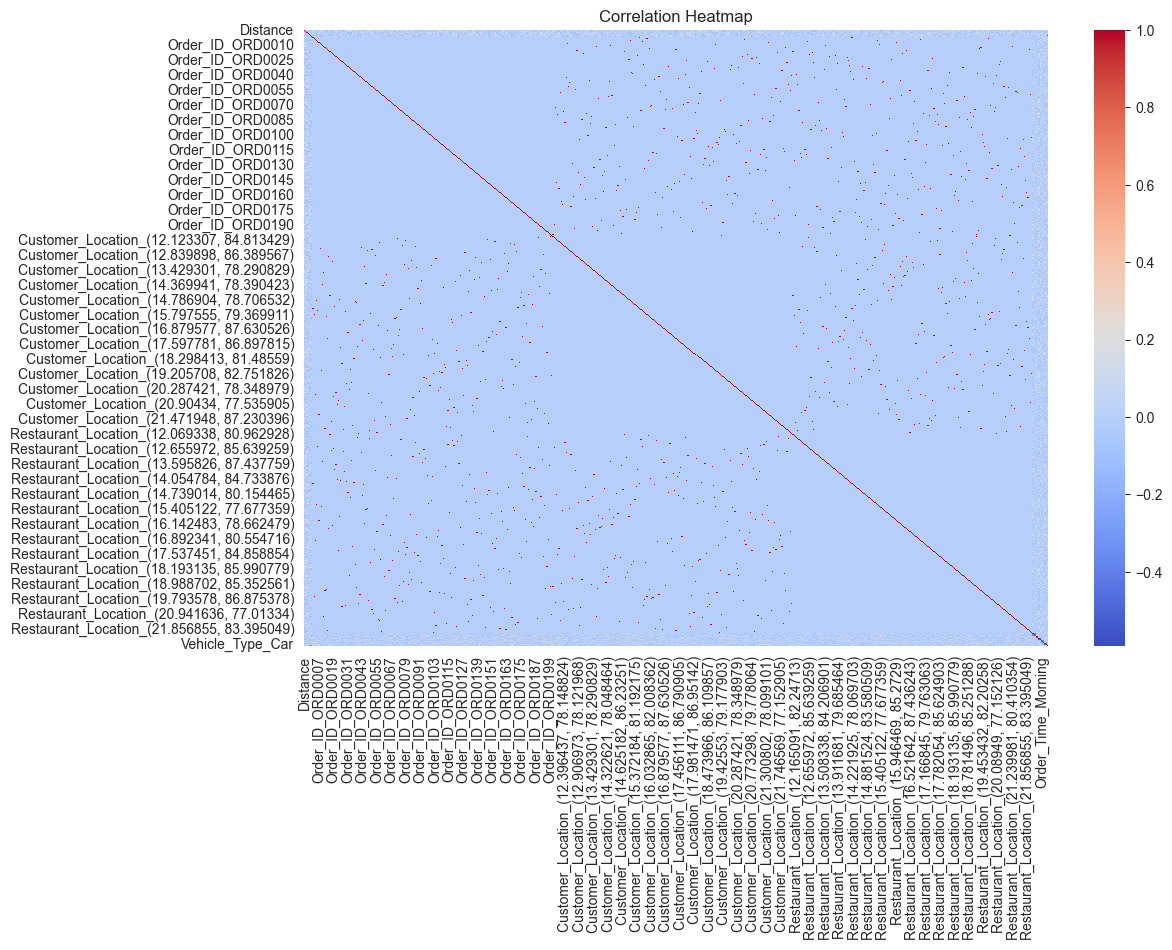

In [66]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [67]:
# Drop target
X_vif = df.drop("Delivery_Time", axis=1)

# Keep only numeric columns
X_vif = X_vif.select_dtypes(include=[np.number])

# Remove infinite values if any
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN (required for VIF)
X_vif = X_vif.dropna()

# Add constant
X_vif = add_constant(X_vif)

# Compute VIF
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

print(vif.sort_values(by="VIF", ascending=False))


                      Feature        VIF
0                       const  71.008477
7                   Tip_Ratio   2.433024
5                  Order_Cost   1.920209
6                  Tip_Amount   1.649475
4             Customer_Rating   1.069723
3           Restaurant_Rating   1.033249
2  Delivery_Person_Experience   1.030170
1                    Distance   1.005668


In [68]:
X = df.drop("Delivery_Time", axis=1)
y = df["Delivery_Time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 941.171495492246
MAE: 25.76827948962687
R2 Score: -0.017602379489201958


In [69]:
df["Delivery_Status"] = np.where(df["Delivery_Time"] > 45, 1, 0)


In [70]:
print(df["Delivery_Status"].value_counts())
print(df["Delivery_Status"].value_counts(normalize=True))


Delivery_Status
1    151
0     49
Name: count, dtype: int64
Delivery_Status
1    0.755
0    0.245
Name: proportion, dtype: float64


In [ ]:
df["Delivery_Status"] = np.where(df["Delivery_Time"] > 45, 1, 0)

X = df.drop(["Delivery_Time", "Delivery_Status"], axis=1)
y = df["Delivery_Status"]

X = X.select_dtypes(include=[np.number])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    class_weight="balanced"
)

log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:,1]


In [72]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.75
Precision: 0.7631578947368421
Recall: 0.9666666666666667
F1 Score: 0.8529411764705882
ROC-AUC: 0.6033333333333334


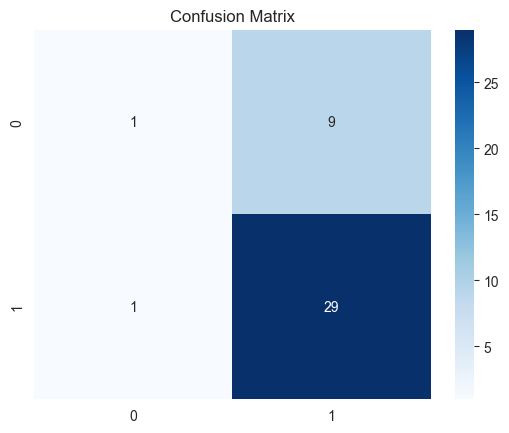

In [73]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


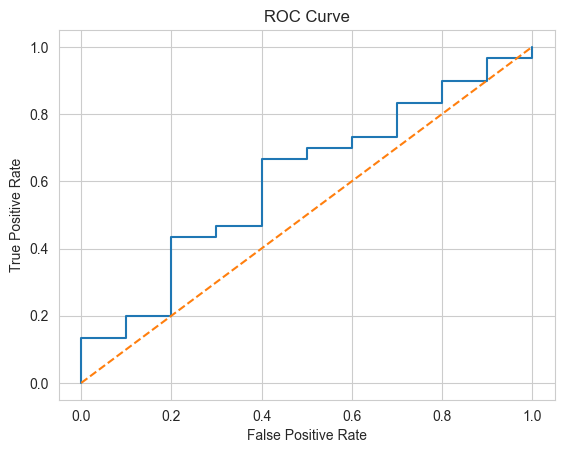

In [74]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [75]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("RF Accuracy:", accuracy_score(y_test, rf_pred))
print("RF ROC-AUC:", roc_auc_score(y_test, rf_prob))


RF Accuracy: 0.75
RF ROC-AUC: 0.4850000000000001


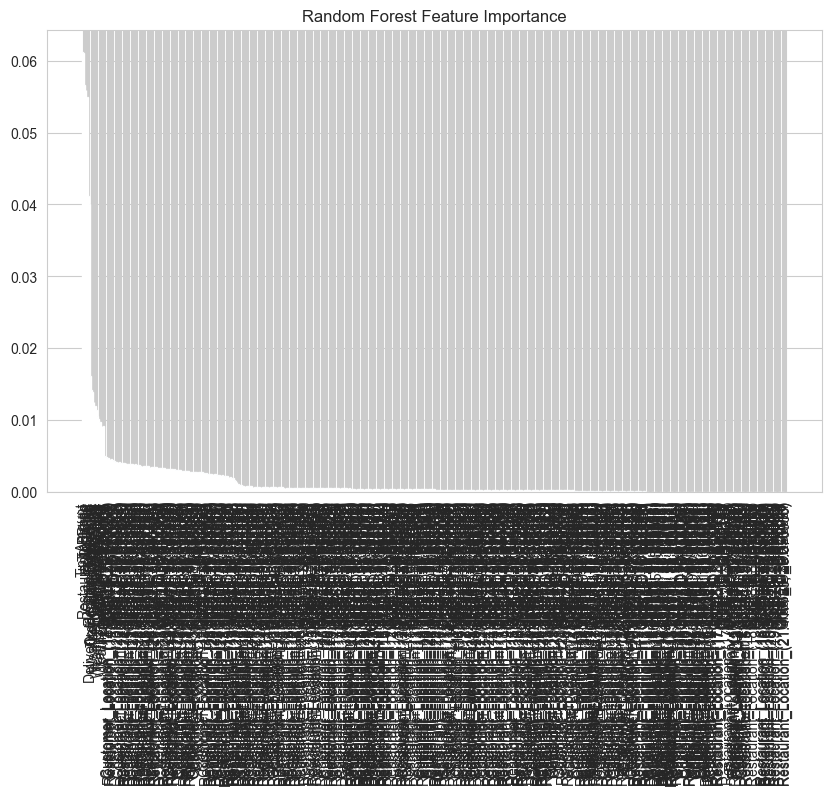

                        Feature  Importance
5                    Tip_Amount    0.061286
2             Restaurant_Rating    0.061114
615                   Tip_Ratio    0.056571
0                      Distance    0.055991
4                    Order_Cost    0.054950
3               Customer_Rating    0.041141
1    Delivery_Person_Experience    0.040008
613           Vehicle_Type_Bike    0.016088
609       Order_Priority_Medium    0.014195
606      Traffic_Conditions_Low    0.013915


In [76]:
importances = rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
plt.show()

print(importance_df.head(10))
